# ROC curves

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_curve, roc_auc_score

from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## ROC curve function

In [2]:
def make_roc_curve(name):
    llr0 = np.load("../data/results/llr_{}_prior.npy".format(name))
    llr1 = np.load("../data/results/llr_{}_shuffledprior.npy".format(name))
    
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0,llr1),0)
    s = s_from_r(np.exp(llr))
    
    fpr, tpr, _ = roc_curve(y, s)
    
    return fpr, tpr


In [3]:
def roc_auc(name):
    llr0 = np.load("../data/results/llr_{}_prior.npy".format(name))
    llr1 = np.load("../data/results/llr_{}_shuffledprior.npy".format(name))
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0,llr1),0)
    s = s_from_r(np.exp(llr))
    
    return roc_auc_score(y, s)


## Data

In [4]:
filenames = ["carl", "carl_aux", "alice", "alice_aux", "alices", "alices_aux"]
labels = ["CARL", "CARL-aux", "ALICE", "ALICE-aux", "ALICES", "ALICES-aux"]
colors = ["C0", "C0", "C1", "C1", "C2", "C2"]
lss = ["-", "--"] * 3

rocs = [make_roc_curve(filename) for filename in filenames]
roc_aucs = [roc_auc(filename) for filename in filenames]

## Plot

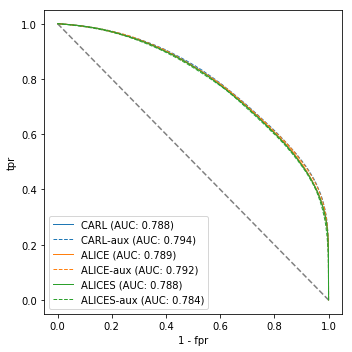

In [5]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
for roc, auc, label, color, ls in zip(rocs, roc_aucs, labels, colors, lss):
    #if "aux" not in label:
    plt.plot(1. - roc[0], roc[1], c=color, lw=1., ls=ls, label=label + " (AUC: {:.3f})".format(auc))

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")

plt.tight_layout()
plt.savefig("../figures/roc.pdf")
